In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pytesseract
import re
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [2]:
def preprocess_for_ocr(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    morphed = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(morphed)
    contour_image = roi.copy()
    margin = 10
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
        cv2.putText(contour_image, f'Area: {int(area)}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        if area >= 300 and (x > margin and y > margin and x + w < roi.shape[1] - margin and y + h < roi.shape[0] - margin):
            cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
    result = cv2.bitwise_and(morphed, morphed, mask=mask)
    resized = cv2.resize(result, None, fx=1, fy=1, interpolation=cv2.INTER_LINEAR)

    # Optional: Display the processed image with contours and areas
    plt.figure(figsize=(6, 6))
    plt.imshow(resized,cmap='gray',aspect='auto')
    plt.title("All Contours and Areas Detected")
    plt.axis('off')
    plt.show()

    return resized

def sanitize_folder_name(text):
    text = re.sub(r'[\\/*?:"<>|]', '', text)
    text = re.sub(r'\s+', '_', text)
    return text

In [3]:
def sort_contours(Filtered):

    Filtered = sorted(Filtered, key=lambda contour_info: contour_info[1][1])  # y-coordinate
    grouped_contours = []
    current_row = []
    last_y = None
    for contour_info in Filtered:
        (_, (cx, cy)) = contour_info

        if last_y is None or abs(cy - last_y) <= 200:
            current_row.append(contour_info)
        else:
            grouped_contours.append(current_row)
            current_row = [contour_info]

        last_y = cy
    if current_row:
        grouped_contours.append(current_row)
    for row in grouped_contours:
        row.sort(key=lambda contour_info: contour_info[1][0])  # x-coordinate
    sorted_contours = [contour for row in grouped_contours for contour in row]

    return sorted_contours


In [4]:
def Image_process(file_nam):

    #Reading the file name from which data need to be extract
    img_read = cv2.imread(file_nam)

    img=img_read
    ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycbcr)

    shadow_mask = cv2.inRange(Cb, 0, 100)  

    # Invert mask to get non-shadow areas
    non_shadow_mask = cv2.bitwise_not(shadow_mask)

    #mask the original image
    img_no_shadows = cv2.bitwise_and(img, img, mask=non_shadow_mask)

    alpha = 1.5 
    beta = 40    

    bright_contrast_img = cv2.convertScaleAbs(img_no_shadows, alpha=alpha, beta=beta)

    sharpening_kernel = np.array([[0, -1, 0],
                                [-1, 5, -1],
                                [0, -1, 0]])

    sharpened_img = cv2.filter2D(bright_contrast_img, -1, sharpening_kernel)


    plt.imshow(sharpened_img,aspect='auto')
    plt.title("Non Binary Image")
    plt.axis('off')
    plt.show()
    
    img_read=sharpened_img
    img_gray = cv2.cvtColor(sharpened_img, cv2.COLOR_BGR2GRAY)

    img_lab = cv2.cvtColor(sharpened_img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(img_lab)

    clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l_channel)

    img_clahe_lab = cv2.merge((l_clahe, a_channel, b_channel))
    img_clahe = cv2.cvtColor(img_clahe_lab, cv2.COLOR_LAB2BGR)

    img_gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(img_gray, (3, 3), 0)




    img_binary = cv2.adaptiveThreshold(img_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 2)
    plt.imshow(img_binary, cmap='gray',aspect='auto')
    plt.title("Binary Image")
    plt.axis('off')
    plt.show()




    def estimate_noise(image):
        stddev = np.std(image)
        return stddev


    def adjust_kernel_size(noise_level, base_size=0, scale_factor=0.003):
        kernel_size = int(base_size + scale_factor * noise_level)
        kernel_size = max(0, kernel_size // 2 * 2 + 1)
        return kernel_size

    noise_level = estimate_noise(img_binary)
    print(f"Estimated noise level: {noise_level}")
    kernel_size = adjust_kernel_size(noise_level, base_size=0, scale_factor=0.003)

    print("kernel",kernel_size)

    img_opened=img_binary
    img_closed=img_binary
    if kernel_size>0 and noise_level>70:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        img_opened = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, kernel)
        img_closed = cv2.morphologyEx(img_opened, cv2.MORPH_CLOSE, kernel)

    img_binary=img_closed

    img_median = cv2.medianBlur(img_binary,5)

    plt.imshow(img_median, cmap='gray',aspect='auto')
    plt.title("Binary Image")
    plt.axis('off')
    plt.show()

    img_shape = np.array(img_median).shape[1] // 160
    print("Structuring element size:", img_shape)


    horizontal_line = cv2.getStructuringElement(cv2.MORPH_RECT, (max(img_shape-5,1), 1))
    horizontal_e = cv2.erode(img_median, horizontal_line, iterations=1)
    horizontal_d = cv2.dilate(horizontal_e, horizontal_line, iterations=9)

    contours, hierarchy = cv2.findContours(horizontal_d, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


    mask = np.zeros_like(horizontal_d)
    min_contour_height = 2000
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > min_contour_height:
            cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
    horizontal_d = cv2.bitwise_and(horizontal_d, mask)

    vertical_line = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img_shape-4))
    vertical_e = cv2.erode(img_median, vertical_line, iterations=1)
    vertical_d = cv2.dilate(vertical_e, vertical_line, iterations=7)
    contours, hierarchy = cv2.findContours(vertical_d, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(vertical_d)
    min_contour_height = 2000
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if h > min_contour_height:
            cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
    vertical_d = cv2.bitwise_and(vertical_d, mask)



    cel_ = cv2.addWeighted(vertical_d, 0.5, horizontal_d, 10, 0.0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    grid_img = cv2.morphologyEx(cel_, cv2.MORPH_CLOSE, kernel)




    plt.imshow(grid_img,cmap='gray',aspect='auto')
    
    #########################################################################################
    
    contours, _ = cv2.findContours(grid_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    Filtered = []

    for contour in contours:
        area = cv2.contourArea(contour)
        print(f"Contour Area: {area}")  

        # Check if the area is greater than a threshold
        if area > 5000 and area<1000000:
            # Approximate the contour
            epsilon = 0.02 * cv2.arcLength(contour, True)  
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if the approximated contour has 4 no round
            if len(approx) >= 3 and len(approx) <=4:

                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = float(w) / h
                
                # Allow for squares and rectangles (relaxed condition)
                if aspect_ratio >= 0.5:
                    Filtered.append((contour, (x + w // 2, y + h // 2)))
                    print(f"Detected rectangular contour with area: {area}, Aspect Ratio: {aspect_ratio:.2f}")

    ###########################################################################################
    
    Filtered = sort_contours(Filtered)

    ##########################################################################################

    output_dir = "extracted_images2"
    os.makedirs(output_dir, exist_ok=True)

    column_counter = 1
    folder_path = "//extracted_images2//"

    #########################################################################################




    current_folder_path = None
    current_row_index = -1  

    for i, (contour, (cx, cy)) in enumerate(Filtered):
        individual_contour_img = img_read.copy()

        cv2.drawContours(individual_contour_img, [contour], -1, (255, 255, 0), 5)

        x, y, w, h = cv2.boundingRect(contour)
        roi = img_read[y:y+h, x:x+w]

        if i % 5 == 0:

            preprocessed_roi = preprocess_for_ocr(roi)

            # Extract text using Tesseract with custom config
            psm_modes = [11, 6, 3,12,9]
            def extract_numeric_text(psm):
                custom_config = f'--oem 3 --psm {psm} -c tessedit_char_whitelist=0123456789'
                extracted_text = pytesseract.image_to_string(preprocessed_roi, config=custom_config).strip()
                return extracted_text
            for psm in psm_modes:
                numeric_text = extract_numeric_text(psm)
                if numeric_text:  
                    break
            first_column_text = numeric_text

            # If no text, generate a default name
            if not first_column_text:
                first_column_text = f"row_{current_row_index + 2}_default"
            # Sanitize the extracted text
            first_column_text = sanitize_folder_name(first_column_text)

            # Create a folder with the name of the extracted text
            current_folder_path = os.path.join(output_dir, first_column_text)
            os.makedirs(current_folder_path, exist_ok=True)

            # Update the current row index
            current_row_index += 1
            print(f"Extracted text from Row {current_row_index + 1}: {first_column_text}")

        else:

            # For columns 2 to 5: Save the image in the folder created
            def remove_borders_with_margin(roi, margin=15):

                h, w = roi.shape[:2]

                roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

                roi = cv2.adaptiveThreshold(roi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 2)

                # Create a mask with the same dimensions as the image
                mask = np.ones((h, w), dtype=np.uint8) * 255

                # Step 3: Apply black margins around the edges
                mask[0:margin, :] = 0  # Top margin
                mask[:, 0:margin] = 0  # Left margin
                mask[h-margin:h, :] = 0  # Bottom margin
                mask[:, w-margin:w] = 0  # Right margin

                # Apply the mask to the original image
                if len(roi.shape) == 3:
                    cleaned_image = cv2.bitwise_and(roi, roi, mask=mask)
                else:
                    cleaned_image = cv2.bitwise_and(roi, mask)  # For grayscale images

                cleaned_image = cv2.medianBlur(cleaned_image, 5)

                # Dilate the image to make contours bolder
                kernel = np.ones((5, 5), np.uint8)  # Structuring element for dilation
                cleaned_image = cv2.dilate(cleaned_image, kernel, iterations=1)

                # Apply Gaussian blur for further smoothing
                cleaned_image = cv2.GaussianBlur(cleaned_image, (5, 5), 0)

                contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Create a blank mask for the final output
                final_mask = np.zeros_like(cleaned_image)

                # Filter contours based on area and draw them on the mask
                for contour in contours:
                    area = cv2.contourArea(contour)
                    if area >= 1000:  # Only keep contours larger than the threshold
                        cv2.drawContours(final_mask, [contour], -1, (255), thickness=cv2.FILLED)

                # Step 11: Apply the final mask to the cleaned image
                result_image = cv2.bitwise_and(cleaned_image, cleaned_image, mask=final_mask)

                return result_image

            margin_size = 50  
            cleaned_roi = remove_borders_with_margin(roi, margin=margin_size)

            column_number = (i % 5) + 1  
            if current_folder_path is not None:  
                image_path = os.path.join(current_folder_path, f"column_{column_number}.png")
                cv2.imwrite(image_path, cleaned_roi)
                print(f"Saved image for Row {current_row_index + 1}, Column {column_number} to {image_path}")

        """

        plt.imshow(cv2.cvtColor(individual_contour_img, cv2.COLOR_BGR2RGB), aspect='auto')
        plt.title(f"Rectangular Contour {i + 1}: Centroid = ({cx}, {cy})")
        plt.axis('off')
        plt.show()

        """
    # Print the total number of large rectangular contours detected
    print(f"Number of rectangular contours with area > 20000: {len(Filtered)}")

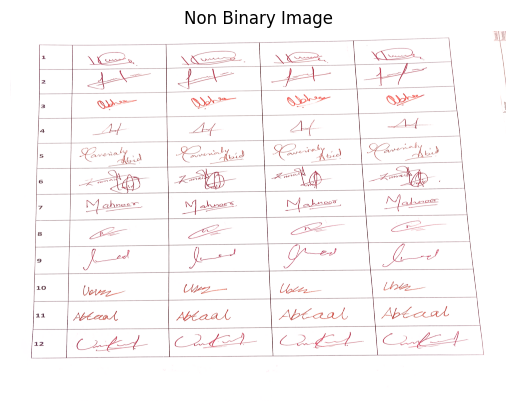

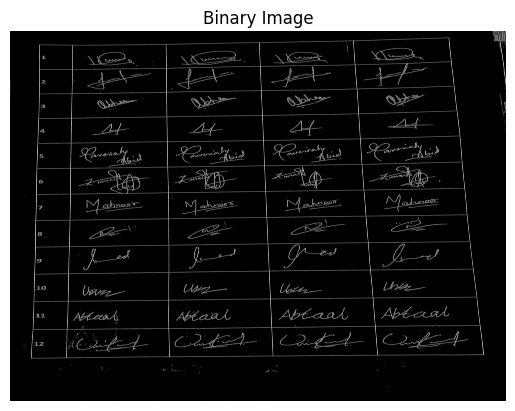

Estimated noise level: 44.9454638303604
kernel 1


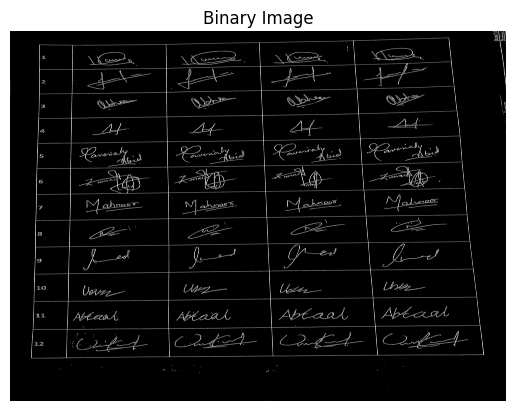

Structuring element size: 37
Contour Area: 251605.5
Detected rectangular contour with area: 251605.5, Aspect Ratio: 0.68
Contour Area: 741399.5
Detected rectangular contour with area: 741399.5, Aspect Ratio: 2.00
Contour Area: 747326.0
Detected rectangular contour with area: 747326.0, Aspect Ratio: 2.00
Contour Area: 762233.0
Detected rectangular contour with area: 762233.0, Aspect Ratio: 2.00
Contour Area: 782344.0
Detected rectangular contour with area: 782344.0, Aspect Ratio: 2.05
Contour Area: 242629.5
Detected rectangular contour with area: 242629.5, Aspect Ratio: 0.69
Contour Area: 728376.0
Detected rectangular contour with area: 728376.0, Aspect Ratio: 1.97
Contour Area: 747965.5
Detected rectangular contour with area: 747965.5, Aspect Ratio: 1.96
Contour Area: 747705.5
Detected rectangular contour with area: 747705.5, Aspect Ratio: 2.00
Contour Area: 753811.0
Detected rectangular contour with area: 753811.0, Aspect Ratio: 2.06
Contour Area: 236764.5
Detected rectangular contour

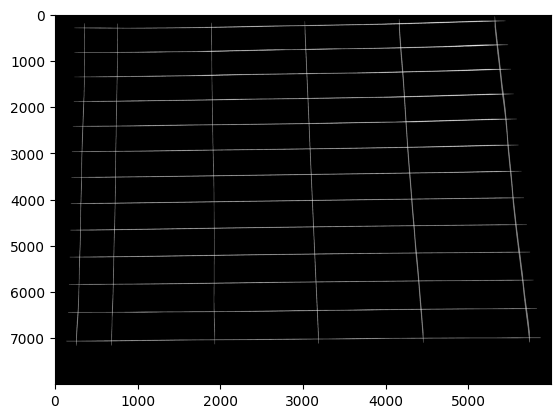

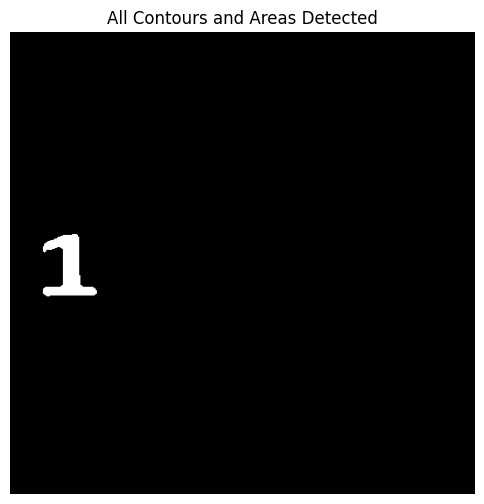

Extracted text from Row 1: 1
Saved image for Row 1, Column 2 to extracted_images2\1\column_2.png
Saved image for Row 1, Column 3 to extracted_images2\1\column_3.png
Saved image for Row 1, Column 4 to extracted_images2\1\column_4.png
Saved image for Row 1, Column 5 to extracted_images2\1\column_5.png


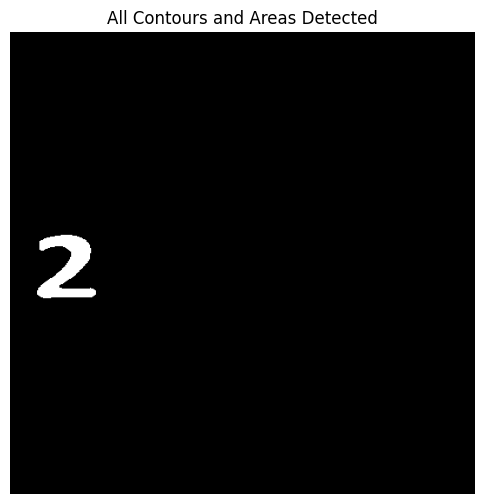

Extracted text from Row 2: 2
Saved image for Row 2, Column 2 to extracted_images2\2\column_2.png
Saved image for Row 2, Column 3 to extracted_images2\2\column_3.png
Saved image for Row 2, Column 4 to extracted_images2\2\column_4.png
Saved image for Row 2, Column 5 to extracted_images2\2\column_5.png


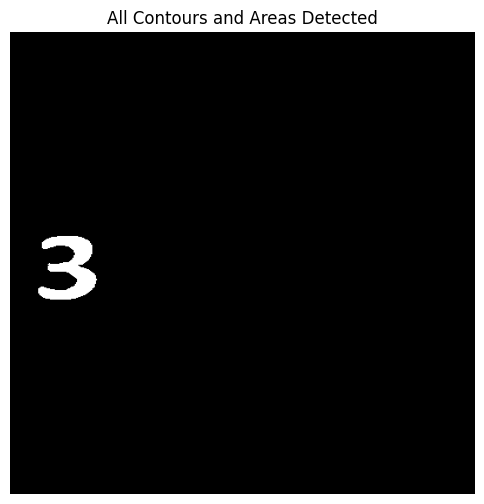

Extracted text from Row 3: 3
Saved image for Row 3, Column 2 to extracted_images2\3\column_2.png
Saved image for Row 3, Column 3 to extracted_images2\3\column_3.png
Saved image for Row 3, Column 4 to extracted_images2\3\column_4.png
Saved image for Row 3, Column 5 to extracted_images2\3\column_5.png


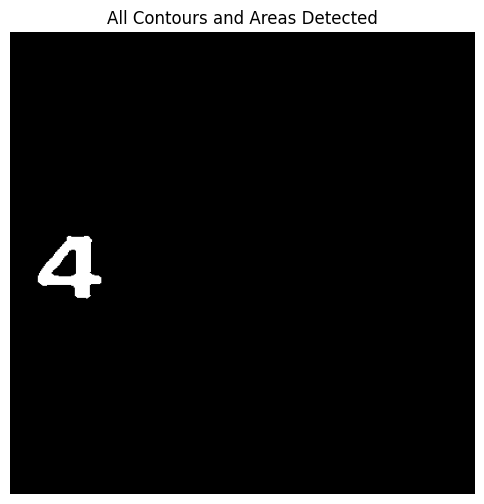

Extracted text from Row 4: 4
Saved image for Row 4, Column 2 to extracted_images2\4\column_2.png
Saved image for Row 4, Column 3 to extracted_images2\4\column_3.png
Saved image for Row 4, Column 4 to extracted_images2\4\column_4.png
Saved image for Row 4, Column 5 to extracted_images2\4\column_5.png


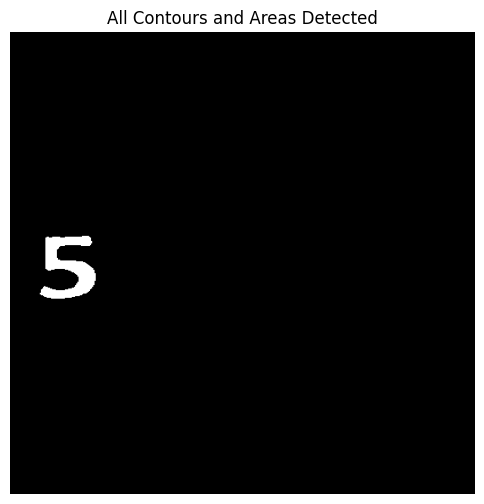

Extracted text from Row 5: 5
Saved image for Row 5, Column 2 to extracted_images2\5\column_2.png
Saved image for Row 5, Column 3 to extracted_images2\5\column_3.png
Saved image for Row 5, Column 4 to extracted_images2\5\column_4.png
Saved image for Row 5, Column 5 to extracted_images2\5\column_5.png


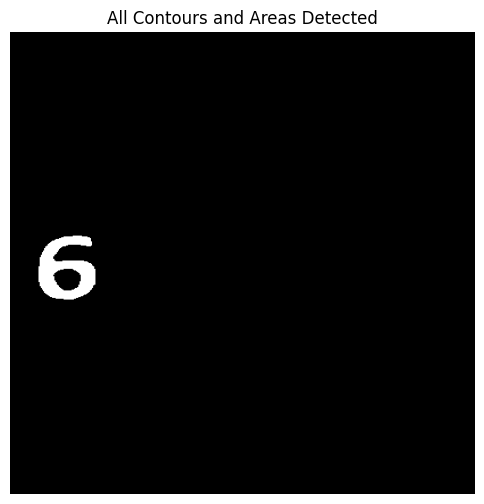

Extracted text from Row 6: row_6_default
Saved image for Row 6, Column 2 to extracted_images2\row_6_default\column_2.png
Saved image for Row 6, Column 3 to extracted_images2\row_6_default\column_3.png
Saved image for Row 6, Column 4 to extracted_images2\row_6_default\column_4.png
Saved image for Row 6, Column 5 to extracted_images2\row_6_default\column_5.png


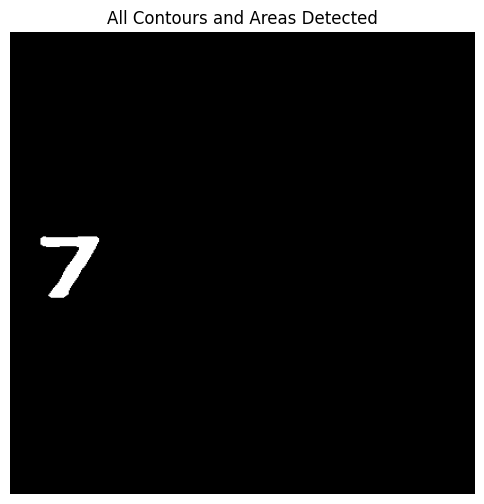

Extracted text from Row 7: 7
Saved image for Row 7, Column 2 to extracted_images2\7\column_2.png
Saved image for Row 7, Column 3 to extracted_images2\7\column_3.png
Saved image for Row 7, Column 4 to extracted_images2\7\column_4.png
Saved image for Row 7, Column 5 to extracted_images2\7\column_5.png


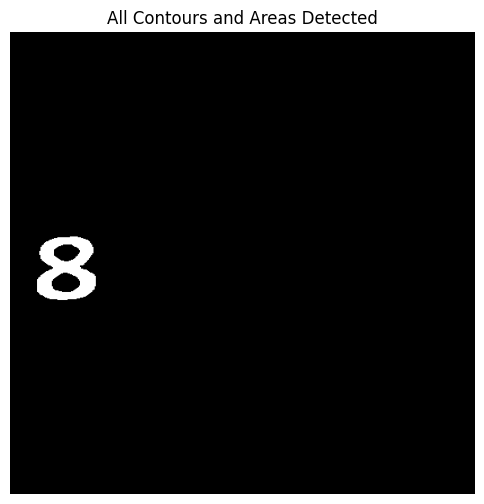

Extracted text from Row 8: 8
Saved image for Row 8, Column 2 to extracted_images2\8\column_2.png
Saved image for Row 8, Column 3 to extracted_images2\8\column_3.png
Saved image for Row 8, Column 4 to extracted_images2\8\column_4.png
Saved image for Row 8, Column 5 to extracted_images2\8\column_5.png


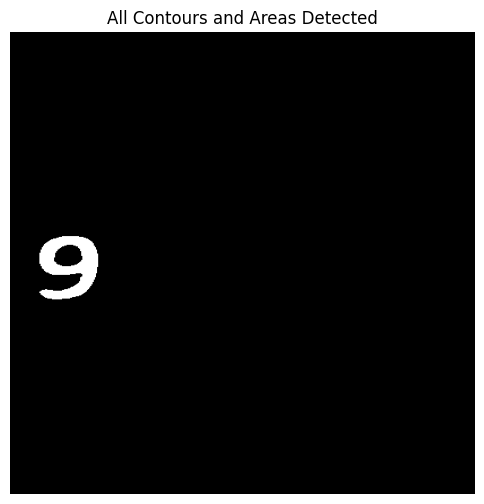

Extracted text from Row 9: 9
Saved image for Row 9, Column 2 to extracted_images2\9\column_2.png
Saved image for Row 9, Column 3 to extracted_images2\9\column_3.png
Saved image for Row 9, Column 4 to extracted_images2\9\column_4.png
Saved image for Row 9, Column 5 to extracted_images2\9\column_5.png


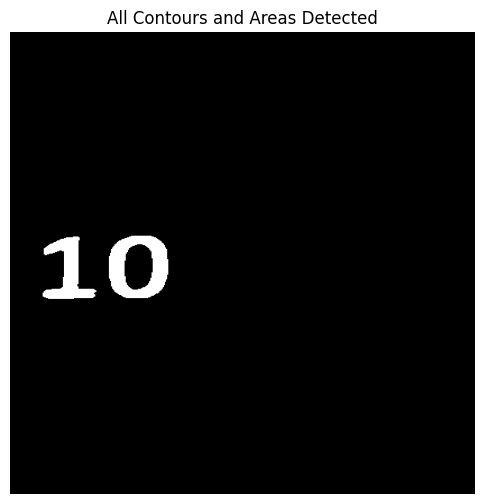

Extracted text from Row 10: 10
Saved image for Row 10, Column 2 to extracted_images2\10\column_2.png
Saved image for Row 10, Column 3 to extracted_images2\10\column_3.png
Saved image for Row 10, Column 4 to extracted_images2\10\column_4.png
Saved image for Row 10, Column 5 to extracted_images2\10\column_5.png


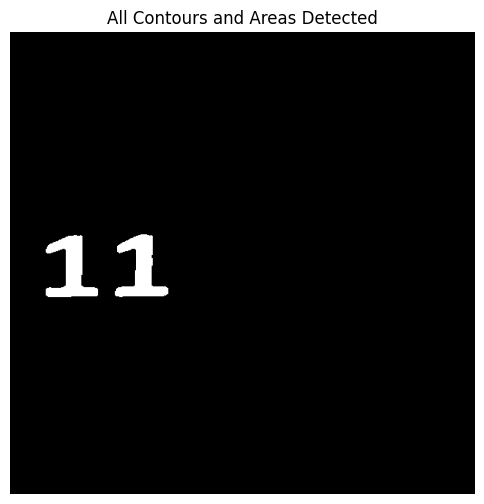

Extracted text from Row 11: 11
Saved image for Row 11, Column 2 to extracted_images2\11\column_2.png
Saved image for Row 11, Column 3 to extracted_images2\11\column_3.png
Saved image for Row 11, Column 4 to extracted_images2\11\column_4.png
Saved image for Row 11, Column 5 to extracted_images2\11\column_5.png


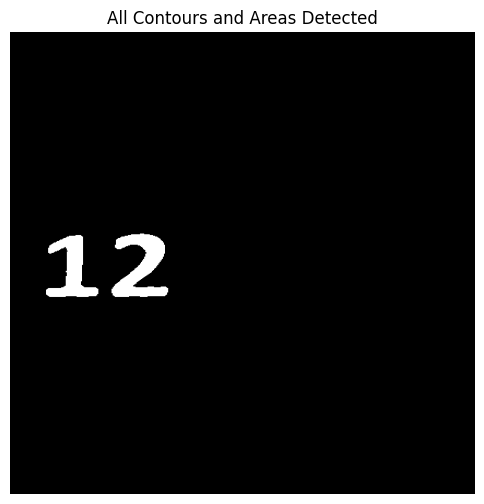

Extracted text from Row 12: 12
Saved image for Row 12, Column 2 to extracted_images2\12\column_2.png
Saved image for Row 12, Column 3 to extracted_images2\12\column_3.png
Saved image for Row 12, Column 4 to extracted_images2\12\column_4.png
Saved image for Row 12, Column 5 to extracted_images2\12\column_5.png
Number of rectangular contours with area > 20000: 60


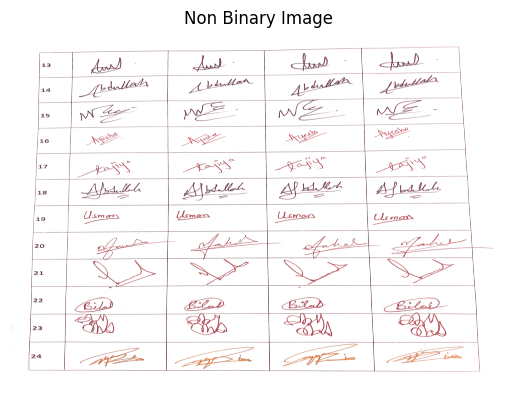

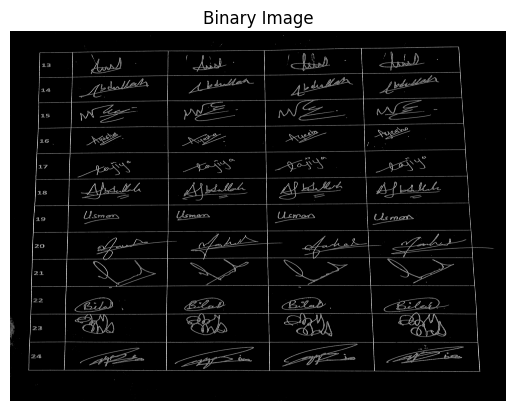

Estimated noise level: 47.53089293684329
kernel 1


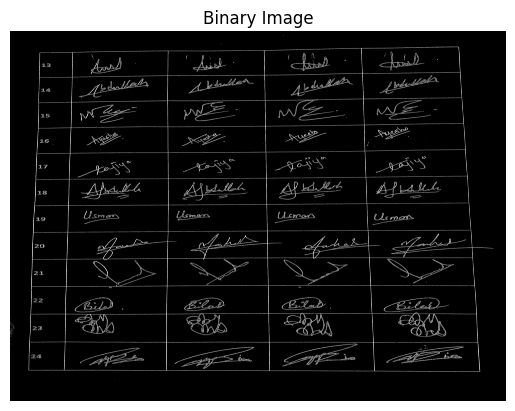

Structuring element size: 37
Contour Area: 780901.0
Detected rectangular contour with area: 780901.0, Aspect Ratio: 2.04
Contour Area: 770000.0
Detected rectangular contour with area: 770000.0, Aspect Ratio: 2.06
Contour Area: 749302.5
Detected rectangular contour with area: 749302.5, Aspect Ratio: 2.05
Contour Area: 254291.5
Detected rectangular contour with area: 254291.5, Aspect Ratio: 0.71
Contour Area: 736279.0
Detected rectangular contour with area: 736279.0, Aspect Ratio: 2.01
Contour Area: 725292.5
Detected rectangular contour with area: 725292.5, Aspect Ratio: 2.03
Contour Area: 248588.5
Detected rectangular contour with area: 248588.5, Aspect Ratio: 0.71
Contour Area: 765264.5
Detected rectangular contour with area: 765264.5, Aspect Ratio: 2.07
Contour Area: 749832.5
Detected rectangular contour with area: 749832.5, Aspect Ratio: 2.01
Contour Area: 767005.0
Detected rectangular contour with area: 767005.0, Aspect Ratio: 2.04
Contour Area: 242068.0
Detected rectangular contour

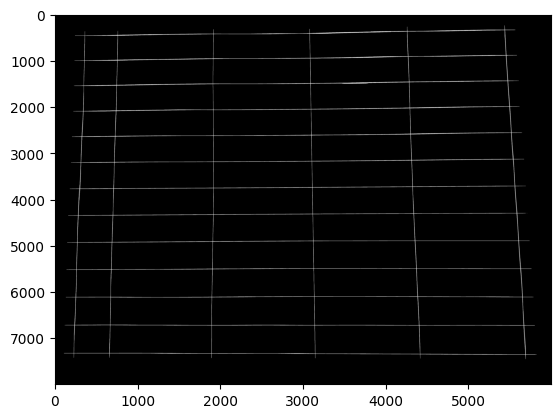

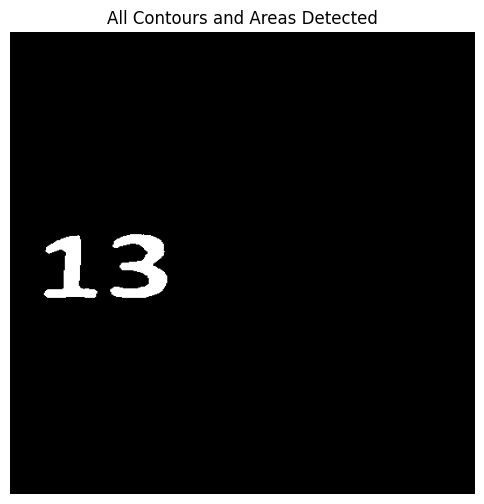

Extracted text from Row 1: 13
Saved image for Row 1, Column 2 to extracted_images2\13\column_2.png
Saved image for Row 1, Column 3 to extracted_images2\13\column_3.png
Saved image for Row 1, Column 4 to extracted_images2\13\column_4.png
Saved image for Row 1, Column 5 to extracted_images2\13\column_5.png


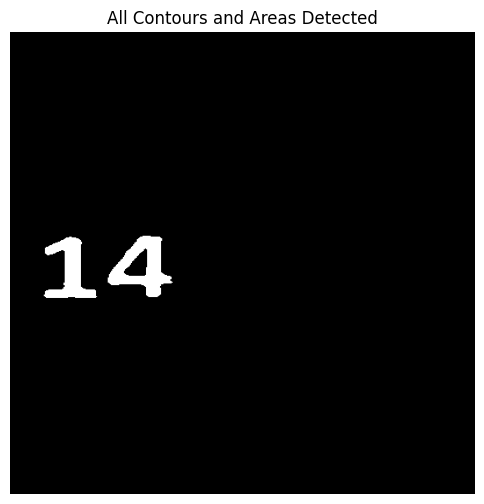

Extracted text from Row 2: 14
Saved image for Row 2, Column 2 to extracted_images2\14\column_2.png
Saved image for Row 2, Column 3 to extracted_images2\14\column_3.png
Saved image for Row 2, Column 4 to extracted_images2\14\column_4.png
Saved image for Row 2, Column 5 to extracted_images2\14\column_5.png


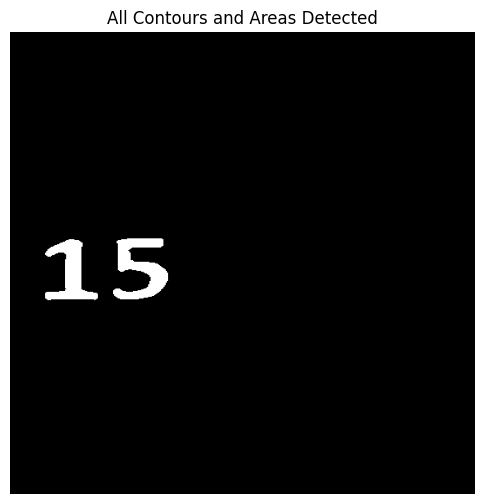

Extracted text from Row 3: 15
Saved image for Row 3, Column 2 to extracted_images2\15\column_2.png
Saved image for Row 3, Column 3 to extracted_images2\15\column_3.png
Saved image for Row 3, Column 4 to extracted_images2\15\column_4.png
Saved image for Row 3, Column 5 to extracted_images2\15\column_5.png


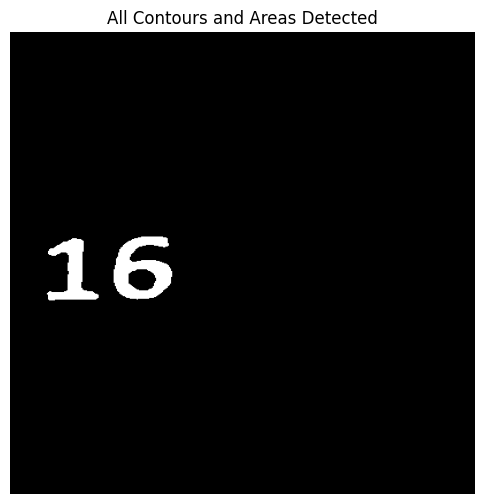

Extracted text from Row 4: 16
Saved image for Row 4, Column 2 to extracted_images2\16\column_2.png
Saved image for Row 4, Column 3 to extracted_images2\16\column_3.png
Saved image for Row 4, Column 4 to extracted_images2\16\column_4.png
Saved image for Row 4, Column 5 to extracted_images2\16\column_5.png


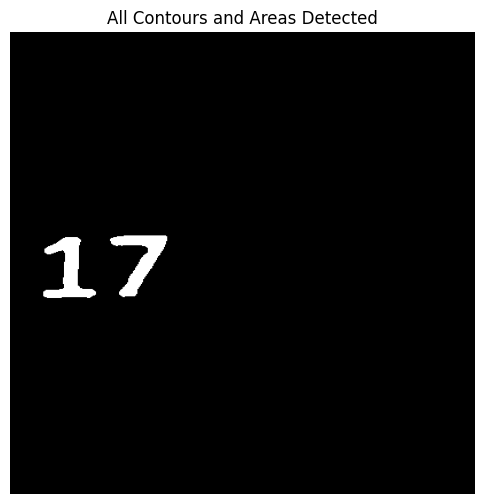

Extracted text from Row 5: 17
Saved image for Row 5, Column 2 to extracted_images2\17\column_2.png
Saved image for Row 5, Column 3 to extracted_images2\17\column_3.png
Saved image for Row 5, Column 4 to extracted_images2\17\column_4.png
Saved image for Row 5, Column 5 to extracted_images2\17\column_5.png


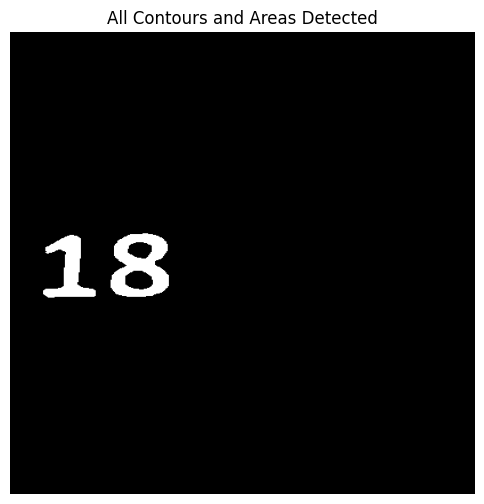

Extracted text from Row 6: 18
Saved image for Row 6, Column 2 to extracted_images2\18\column_2.png
Saved image for Row 6, Column 3 to extracted_images2\18\column_3.png
Saved image for Row 6, Column 4 to extracted_images2\18\column_4.png
Saved image for Row 6, Column 5 to extracted_images2\18\column_5.png


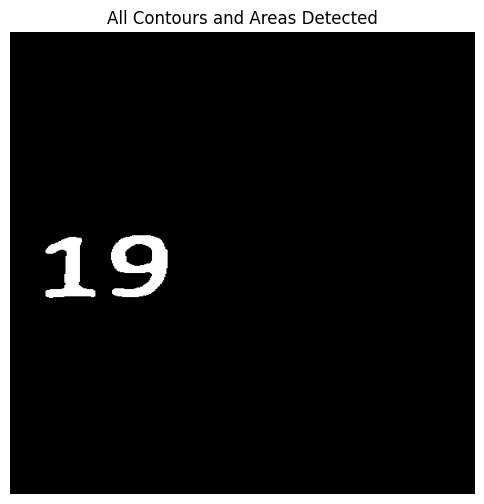

Extracted text from Row 7: 19
Saved image for Row 7, Column 2 to extracted_images2\19\column_2.png
Saved image for Row 7, Column 3 to extracted_images2\19\column_3.png
Saved image for Row 7, Column 4 to extracted_images2\19\column_4.png
Saved image for Row 7, Column 5 to extracted_images2\19\column_5.png


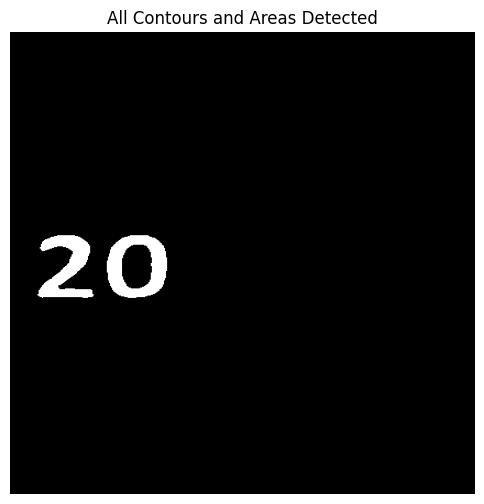

Extracted text from Row 8: 20
Saved image for Row 8, Column 2 to extracted_images2\20\column_2.png
Saved image for Row 8, Column 3 to extracted_images2\20\column_3.png
Saved image for Row 8, Column 4 to extracted_images2\20\column_4.png
Saved image for Row 8, Column 5 to extracted_images2\20\column_5.png


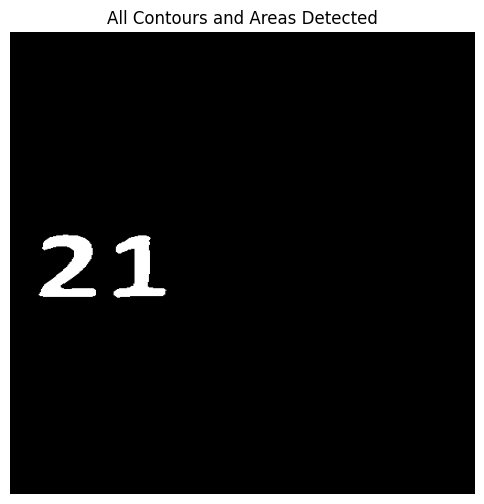

Extracted text from Row 9: 21
Saved image for Row 9, Column 2 to extracted_images2\21\column_2.png
Saved image for Row 9, Column 3 to extracted_images2\21\column_3.png
Saved image for Row 9, Column 4 to extracted_images2\21\column_4.png
Saved image for Row 9, Column 5 to extracted_images2\21\column_5.png


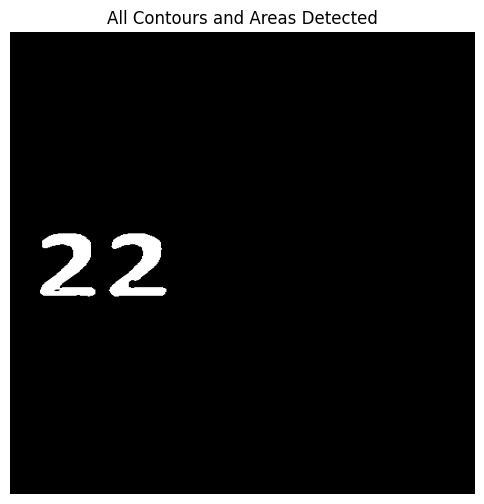

Extracted text from Row 10: 22
Saved image for Row 10, Column 2 to extracted_images2\22\column_2.png
Saved image for Row 10, Column 3 to extracted_images2\22\column_3.png
Saved image for Row 10, Column 4 to extracted_images2\22\column_4.png
Saved image for Row 10, Column 5 to extracted_images2\22\column_5.png


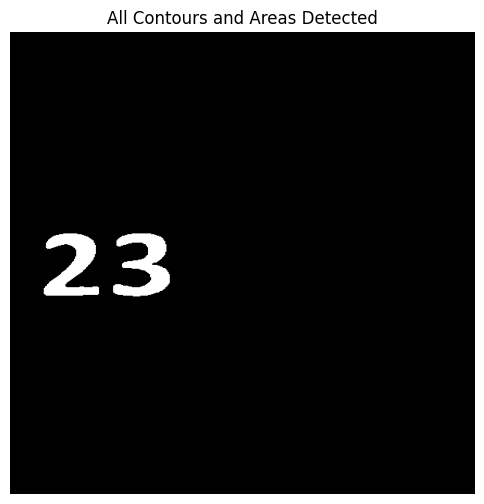

Extracted text from Row 11: 23
Saved image for Row 11, Column 2 to extracted_images2\23\column_2.png
Saved image for Row 11, Column 3 to extracted_images2\23\column_3.png
Saved image for Row 11, Column 4 to extracted_images2\23\column_4.png
Saved image for Row 11, Column 5 to extracted_images2\23\column_5.png


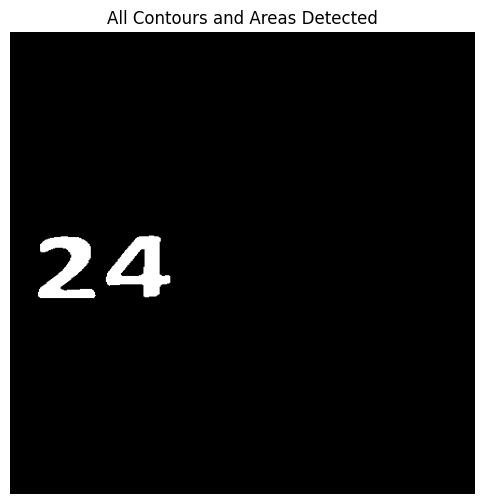

Extracted text from Row 12: 24
Saved image for Row 12, Column 2 to extracted_images2\24\column_2.png
Saved image for Row 12, Column 3 to extracted_images2\24\column_3.png
Saved image for Row 12, Column 4 to extracted_images2\24\column_4.png
Saved image for Row 12, Column 5 to extracted_images2\24\column_5.png
Number of rectangular contours with area > 20000: 60


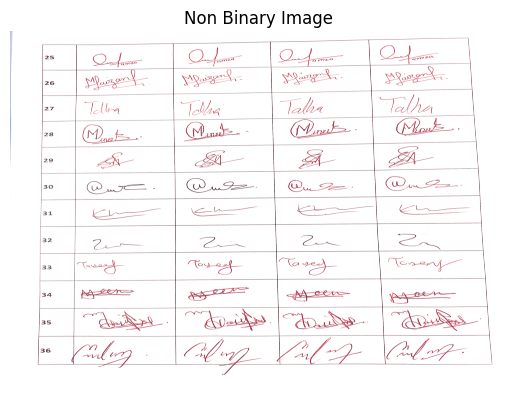

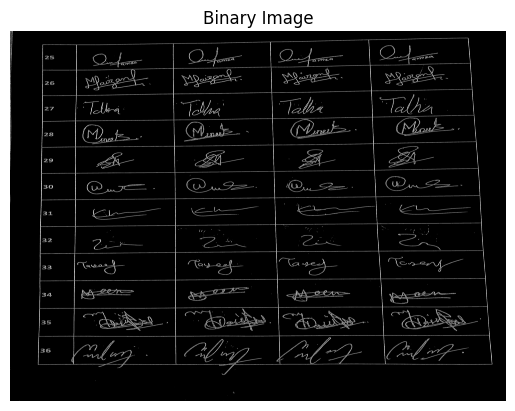

Estimated noise level: 47.704267060983554
kernel 1


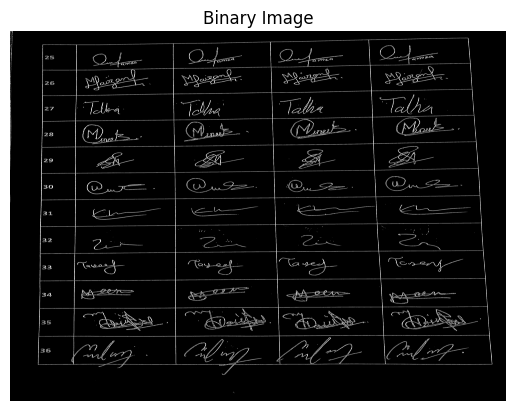

Structuring element size: 37
Contour Area: 736594.5
Detected rectangular contour with area: 736594.5, Aspect Ratio: 2.04
Contour Area: 253817.0
Detected rectangular contour with area: 253817.0, Aspect Ratio: 0.70
Contour Area: 756087.5
Detected rectangular contour with area: 756087.5, Aspect Ratio: 2.06
Contour Area: 766969.0
Detected rectangular contour with area: 766969.0, Aspect Ratio: 2.06
Contour Area: 786120.5
Detected rectangular contour with area: 786120.5, Aspect Ratio: 2.08
Contour Area: 246495.0
Detected rectangular contour with area: 246495.0, Aspect Ratio: 0.70
Contour Area: 733532.0
Detected rectangular contour with area: 733532.0, Aspect Ratio: 2.04
Contour Area: 754061.5
Detected rectangular contour with area: 754061.5, Aspect Ratio: 2.03
Contour Area: 761078.5
Detected rectangular contour with area: 761078.5, Aspect Ratio: 2.05
Contour Area: 770413.0
Detected rectangular contour with area: 770413.0, Aspect Ratio: 2.09
Contour Area: 240528.5
Detected rectangular contour

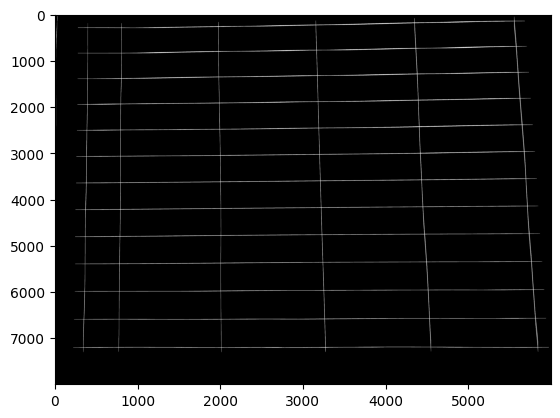

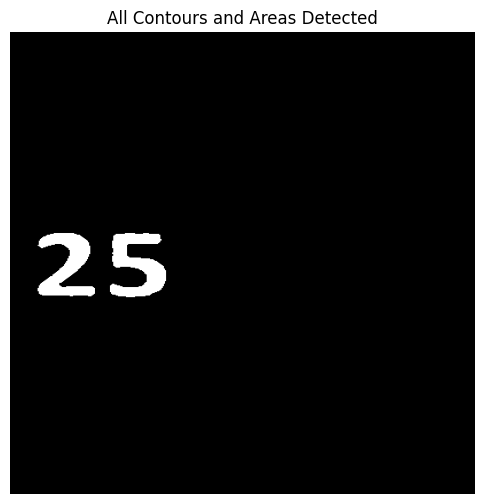

Extracted text from Row 1: 25
Saved image for Row 1, Column 2 to extracted_images2\25\column_2.png
Saved image for Row 1, Column 3 to extracted_images2\25\column_3.png
Saved image for Row 1, Column 4 to extracted_images2\25\column_4.png
Saved image for Row 1, Column 5 to extracted_images2\25\column_5.png


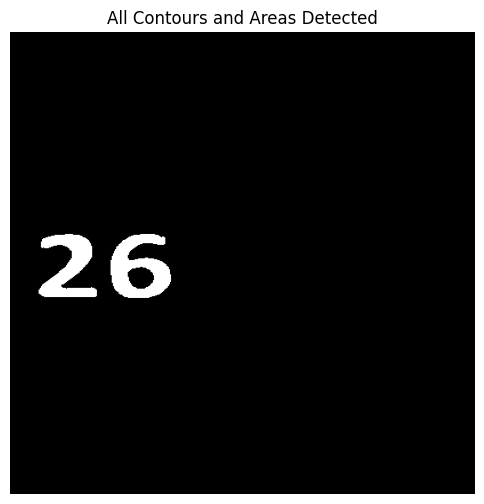

Extracted text from Row 2: 26
Saved image for Row 2, Column 2 to extracted_images2\26\column_2.png
Saved image for Row 2, Column 3 to extracted_images2\26\column_3.png
Saved image for Row 2, Column 4 to extracted_images2\26\column_4.png
Saved image for Row 2, Column 5 to extracted_images2\26\column_5.png


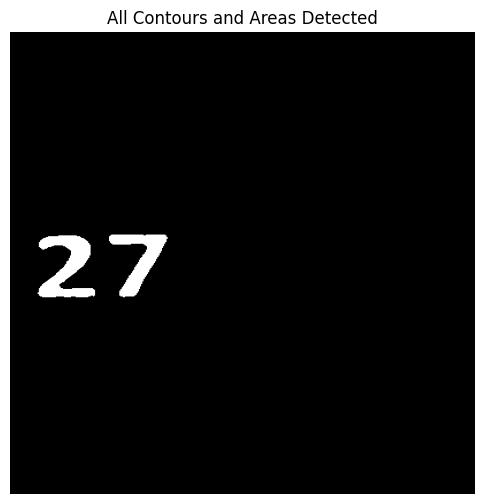

Extracted text from Row 3: 27
Saved image for Row 3, Column 2 to extracted_images2\27\column_2.png
Saved image for Row 3, Column 3 to extracted_images2\27\column_3.png
Saved image for Row 3, Column 4 to extracted_images2\27\column_4.png
Saved image for Row 3, Column 5 to extracted_images2\27\column_5.png


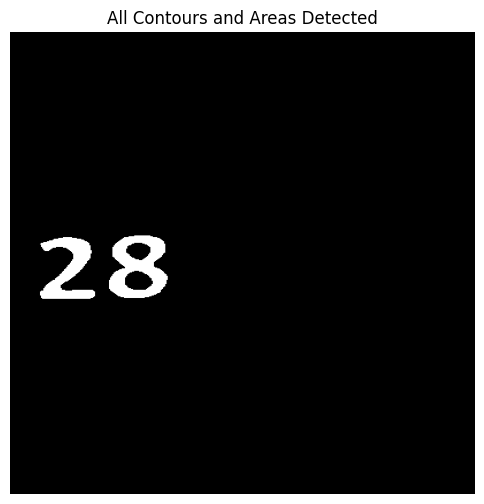

Extracted text from Row 4: 28
Saved image for Row 4, Column 2 to extracted_images2\28\column_2.png
Saved image for Row 4, Column 3 to extracted_images2\28\column_3.png
Saved image for Row 4, Column 4 to extracted_images2\28\column_4.png
Saved image for Row 4, Column 5 to extracted_images2\28\column_5.png


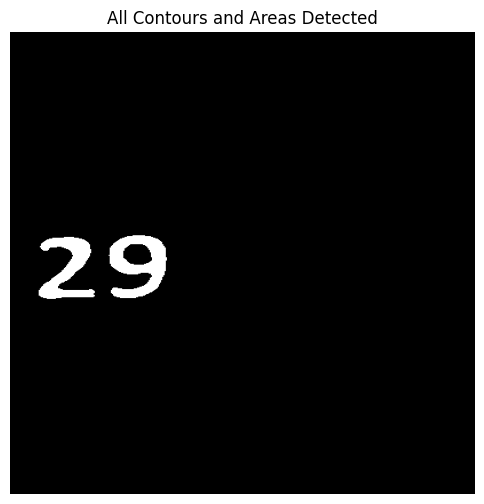

Extracted text from Row 5: 29
Saved image for Row 5, Column 2 to extracted_images2\29\column_2.png
Saved image for Row 5, Column 3 to extracted_images2\29\column_3.png
Saved image for Row 5, Column 4 to extracted_images2\29\column_4.png
Saved image for Row 5, Column 5 to extracted_images2\29\column_5.png


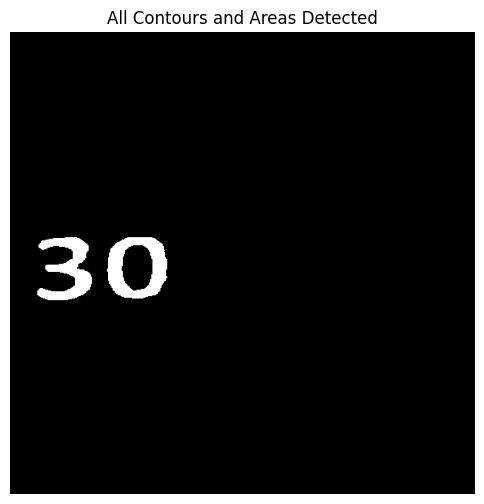

Extracted text from Row 6: 30
Saved image for Row 6, Column 2 to extracted_images2\30\column_2.png
Saved image for Row 6, Column 3 to extracted_images2\30\column_3.png
Saved image for Row 6, Column 4 to extracted_images2\30\column_4.png
Saved image for Row 6, Column 5 to extracted_images2\30\column_5.png


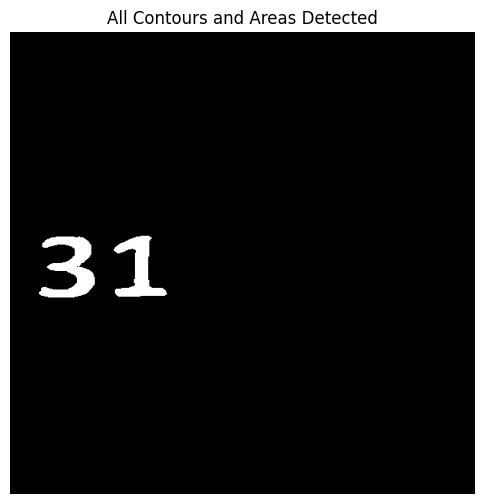

Extracted text from Row 7: 31
Saved image for Row 7, Column 2 to extracted_images2\31\column_2.png
Saved image for Row 7, Column 3 to extracted_images2\31\column_3.png
Saved image for Row 7, Column 4 to extracted_images2\31\column_4.png
Saved image for Row 7, Column 5 to extracted_images2\31\column_5.png


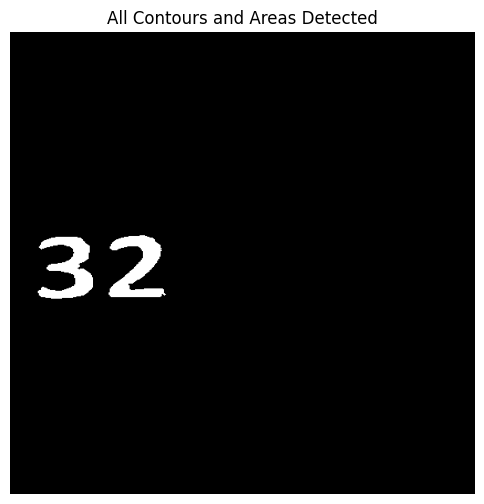

Extracted text from Row 8: 32


KeyboardInterrupt: 

In [5]:
folder_path = "Data"

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path):
        Image_process(file_path)


In [ ]:
Image_process("Data\\20240904_091404.jpg")